In [1]:
#https://www.kaggle.com/lisphilar/covid-19-data-with-sir-model

In [7]:
import gc
import datetime
from datetime import date, timedelta, datetime
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
import seaborn as sns
import matplotlib.pyplot as plt
cmap = plt.get_cmap('jet_r')
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')
from scipy.optimize import curve_fit
import folium
import branca
%matplotlib inline

In [8]:
# Download latest data
if 1:
    import data_pull_jhu

In [9]:
df_table = pd.read_csv('../input/covid_19_master.csv', parse_dates=['Last Update'])
df_table['Day'] = df_table['Date'].apply(lambda x: (datetime.strptime(x, '%m-%d-%Y')-datetime(2020, 1, 22)).days)
df_table.drop(df_table[df_table['Date'] == '03-12-2020'].index, inplace=True)
#df_table['Date'] = pd.DatetimeIndex(df_table['Last Update']).normalize()
dates = np.unique(df_table['Date'])
df_latest = df_table[df_table['Date'] == max(df_table['Date'])].reset_index()
df_latest_grouped = df_latest.groupby('Country/Region')[
    'Confirmed', 'Deaths', 'Recovered'].sum().reset_index()

In [15]:
df_table[df_table['Country/Region']=='Turkey']

,Unnamed: 0,Confirmed,Country/Region,Date,Deaths,Last Update,Latitude,Longitude,Province/State,Recovered,Active,Closed,Day
4915,4915,1.0,Turkey,03-11-2020,0.0,2020-03-11 03:33:05,38.9637,35.2433,NaN,0.0,1.0,0.0,49
5233,5233,5.0,Turkey,03-13-2020,0.0,2020-03-11 20:00:00,38.9637,35.2433,NaN,0.0,5.0,0.0,51
5562,5562,5.0,Turkey,03-14-2020,0.0,2020-03-13 23:33:06,38.9637,35.2433,NaN,0.0,5.0,0.0,52
5811,5811,6.0,Turkey,03-15-2020,0.0,2020-03-15 18:20:18,38.9637,35.2433,NaN,0.0,6.0,0.0,53
6045,6045,18.0,Turkey,03-16-2020,0.0,2020-03-16 01:13:13,38.9637,35.2433,NaN,0.0,18.0,0.0,54
6290,6290,47.0,Turkey,03-17-2020,1.0,2020-03-17 22:13:16,38.9637,35.2433,NaN,0.0,46.0,1.0,55
6532,6532,98.0,Turkey,03-18-2020,1.0,2020-03-18 02:33:06,38.9637,35.2433,NaN,0.0,97.0,1.0,56


In [10]:
sdate = datetime(2020, 1, 22)
date_arr = np.array(['00-00-0000' for i in range(np.max(df_table['Day'])+1)]).copy()
for day in np.unique(df_table['Day']):
    date = sdate + timedelta(days=int(day))
    date_arr[day] = date.strftime('%m-%d-%Y')

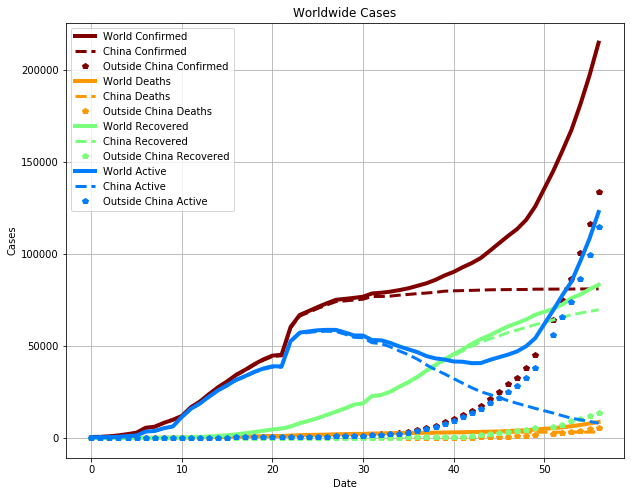

In [11]:
# Worldwide cases
plt.figure(figsize=(10, 8))
cols = ['Confirmed', 'Deaths', 'Recovered', 'Active']
country = 'China'
#continent = 'Asia'
for ic, col in enumerate(cols):
    plt.plot(df_table.groupby('Day').sum()[col], '-', 
             c=cmap(np.arange(0, 1, 1./len(cols)))[ic], linewidth=4, label='World '+col)
    plt.plot(df_table[df_table['Country/Region']==country].groupby('Day').sum()[
        col], '--', c=cmap(np.arange(0, 1, 1./len(cols)))[ic], linewidth=3, label=country+' '+col)
    plt.plot(df_table[df_table['Country/Region']!=country].groupby('Day').sum()[
        col], 'p', c=cmap(np.arange(0, 1, 1./len(cols)))[ic], linewidth=3, label='Outside '+country+' '+col)

plt.title('Worldwide Cases')
plt.xlabel('Date')
#plt.xticks(dates[::4], rotation=20)
plt.ylabel('Cases')
plt.grid()
plt.legend()
plt.savefig('../figs/world_cases.png')

In [12]:
#df_c = df_table[df_table['Country/Region']==country].groupby('Day').sum().reset_index()
#plt.plot(df_c['Day'].apply(lambda x: date_arr[x]), df_c['Confirmed'])

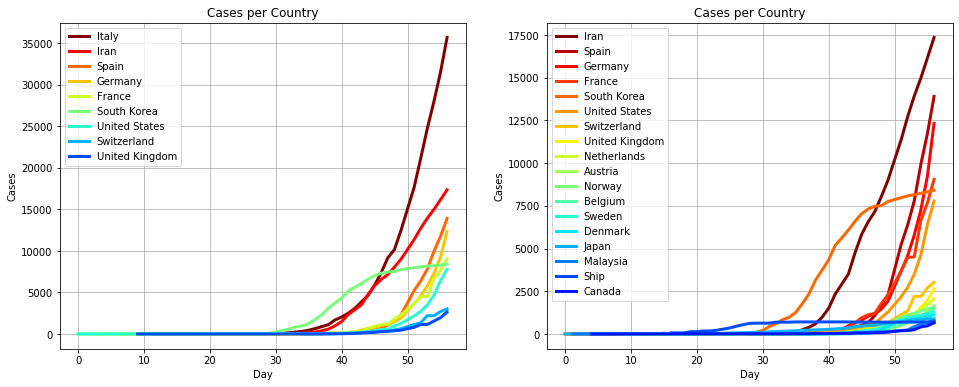

In [13]:
# Cases per country
plt.figure(figsize=(16, 6))
Nc = [[1,10],[2,20]]
for ifig in range(2):
    plt.subplot(1, 2, ifig+1)
    countries = df_latest_grouped.sort_values(by='Confirmed', ascending=False)['Country/Region'].values[Nc[ifig][0]:Nc[ifig][1]]
    for ic, country in enumerate(countries):
        df_c = df_table[df_table['Country/Region']==country].groupby('Day').sum().reset_index()
        plt.plot(df_c['Day'], df_c['Confirmed'], '-', c=cmap(np.arange(0, 1, 1./Nc[ifig][1]))[ic], 
                 label=country, linewidth=3)    
        #if ic == 0: plt.xticks(df_c['Day'][::5], rotation=20)     
    plt.title('Cases per Country')
    plt.xlabel('Day')
    plt.ylabel('Cases')
    plt.grid()
    plt.legend()

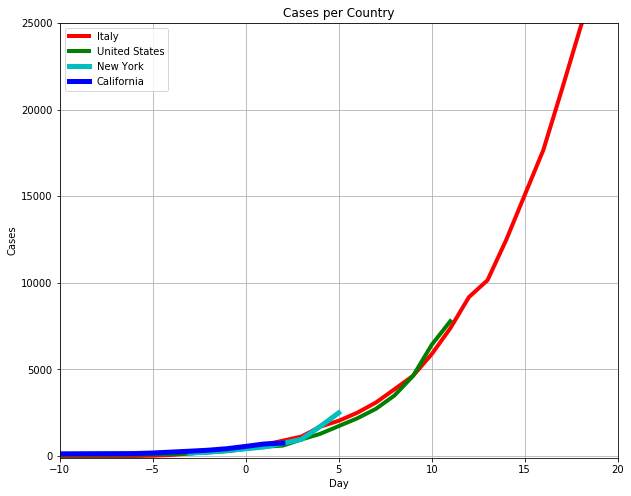

In [14]:
plt.figure(figsize=(10, 8))
#df_p = df_table[df_table['Province/State']=='Hubei']
#plt.plot(df_p['Day'], df_p['Confirmed'], '-', linewidth=4, label='Wuhan')
df_c = df_table[df_table['Country/Region']=='Italy'].groupby('Day').sum().reset_index()
plt.plot(df_c['Day']-35, df_c['Confirmed'], '-r', linewidth=4, label='Italy')
df_c = df_table[df_table['Country/Region']=='United States'].groupby('Day').sum().reset_index()
plt.plot(df_c['Day']-45, df_c['Confirmed'], '-g', linewidth=4, label='United States')
df_p = df_table[df_table['Province/State']=='New York']
plt.plot(df_p['Day']-51, df_p['Confirmed'], '-c', linewidth=5, label='New York')
df_p = df_table[df_table['Province/State']=='California']
plt.plot(df_p['Day']-54, df_p['Confirmed'], '-b', linewidth=5, label='California')
plt.title('Cases per Country')
plt.xlabel('Day')
plt.ylabel('Cases')
plt.xlim([-10, 20])
plt.ylim([-100, 25000])
plt.grid()
plt.legend()
plt.savefig('../figs/compare_US_Italy_California.png')